# <font color='navy'> Backtest

In [1]:
import ta
import optuna
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
np.random.seed(42)
warnings.filterwarnings("ignore")

In [2]:
from dataclasses import dataclass


@dataclass
class Operation:
    time: str
    price: float
    stop_loss: float
    take_profit: float
    n_shares: int
    type: str

In [3]:
def get_portfolio_value(cash: float, long_ops: list[Operation], short_ops: list[Operation], current_price:float, n_shares: int) -> float:
    val = cash

    # Add long positions value
    val += len(long_ops) * current_price * n_shares

    # TODO: Add short positions value
    return val

In [4]:
data = pd.read_csv('aapl_5m_train.csv').dropna()
data.head()

,Unnamed: 0,Timestamp,Gmtoffset,Datetime,Open,High,Low,Close,Volume
0,0,1609770600,0,2021-01-04 14:30:00,133.570007,133.611602,132.389999,132.809997,6624663.0
1,1,1609770900,0,2021-01-04 14:35:00,132.750000,132.750000,131.809997,131.889999,2541553.0
2,2,1609771200,0,2021-01-04 14:40:00,131.500000,132.339996,131.500000,132.059997,2492415.0
3,3,1609771500,0,2021-01-04 14:45:00,132.000000,132.250000,131.899993,132.250000,1859131.0
4,4,1609771800,0,2021-01-04 14:50:00,132.000000,132.018096,131.520004,131.589996,1780105.0


## <font color='cornflowerblue'> Optimización de hiperparámetros

In [5]:
def backtest(data, trial) -> float:
    data = data.copy()

    rsi_window = trial.suggest_int('rsi_window', 5, 50)
    rsi_lower = trial.suggest_int('rsi_lower', 5, 35)
    rsi_upper = trial.suggest_int('rsi_upper', 65, 95)
    stop_loss = trial.suggest_float('stop_loss', 0.01, 0.15)
    take_profit = trial.suggest_float('take_profit', 0.01, 0.15)
    n_shares = trial.suggest_int('n_shares', 50, 500)

    rsi_indicator = ta.momentum.RSIIndicator(data.Close, window=rsi_window)
    data['rsi'] = rsi_indicator.rsi()

    historic = data.dropna()
    historic['buy_signal'] = historic.rsi < rsi_lower
    historic['sell_signal'] = historic.rsi > rsi_upper

    COM = 0.125 / 100
    SL = stop_loss
    TP = take_profit
    BORROW_RATE = 0.25 / 100

    cash = 1_000_000

    active_long_positions: list[Operation] = []

    portfolio_value = [cash]

    for i, row in historic.iterrows():
        # This only works for long positions

        # Close positions
        for position in active_long_positions.copy():
            if row.Close > position.take_profit or row.Close < position.stop_loss:
                cash += row.Close * position.n_shares * (1 - COM)
                active_long_positions.remove(position)
        # --- BUY ---
        # Check signal
        if not row.buy_signal:
            portfolio_value.append(get_portfolio_value(
                cash, active_long_positions, [], row.Close, n_shares))
            continue
        # Do we have enough cash?
        if cash < row.Close * n_shares * (1 + COM):
            portfolio_value.append(get_portfolio_value(
                cash, active_long_positions, [], row.Close, n_shares))
            continue
        # Discount the cost
        cash -= row.Close * n_shares * (1 + COM)
        # Save the operation as active position
        active_long_positions.append(
            Operation(
                time=row.Datetime,
                price=row.Close,
                take_profit=row.Close * (1 + TP),
                stop_loss=row.Close * (1 - SL),
                n_shares=n_shares,
                type="LONG"
            )
        )

        portfolio_value.append(get_portfolio_value(
            cash, active_long_positions, [], row.Close, n_shares))

    cash += row.Close * len(active_long_positions) * n_shares * (1 - COM)
    active_long_positions = []

    return (cash / 1_000_000) - 1

In [6]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: backtest(data, trial), n_trials=50, n_jobs=-1)

[I 2025-09-12 14:43:31,116] A new study created in memory with name: no-name-5c3b104b-9b82-4163-a180-d72243817159
[I 2025-09-12 14:43:35,717] Trial 0 finished with value: 0.04505014870496016 and parameters: {'rsi_window': 33, 'rsi_lower': 17, 'rsi_upper': 89, 'stop_loss': 0.13040106906229132, 'take_profit': 0.06308636384879657, 'n_shares': 448}. Best is trial 0 with value: 0.04505014870496016.
[I 2025-09-12 14:43:36,138] Trial 4 finished with value: 0.0139164698063734 and parameters: {'rsi_window': 18, 'rsi_lower': 14, 'rsi_upper': 65, 'stop_loss': 0.14964270411590352, 'take_profit': 0.018959315601868944, 'n_shares': 231}. Best is trial 0 with value: 0.04505014870496016.
[I 2025-09-12 14:43:36,230] Trial 7 finished with value: 0.0 and parameters: {'rsi_window': 28, 'rsi_lower': 7, 'rsi_upper': 92, 'stop_loss': 0.02961341841096447, 'take_profit': 0.0697516226563137, 'n_shares': 169}. Best is trial 0 with value: 0.04505014870496016.
[I 2025-09-12 14:43:38,509] Trial 6 finished with value

## <font color='cornflowerblue'> Resultados

In [7]:
study.best_params

{'rsi_window': 25,
 'rsi_lower': 22,
 'rsi_upper': 90,
 'stop_loss': 0.13948251326772546,
 'take_profit': 0.13805991986348903,
 'n_shares': 494}

In [8]:
study.best_value

0.4478418564737663

## <font color='cornflowerblue'> Uso de resultados óptimos

In [9]:
window = study.best_params['rsi_window']
lower = study.best_params['rsi_lower']
upper = study.best_params['rsi_upper']

SL = study.best_params['stop_loss']
TP = study.best_params['take_profit']
n_shares = study.best_params['n_shares']

COM = 0.125 / 100
BORROW_RATE = 0.25 / 100
cash = 1_000_000

In [10]:
data = pd.read_csv('aapl_5m_train.csv').dropna()
data.head()

,Unnamed: 0,Timestamp,Gmtoffset,Datetime,Open,High,Low,Close,Volume
0,0,1609770600,0,2021-01-04 14:30:00,133.570007,133.611602,132.389999,132.809997,6624663.0
1,1,1609770900,0,2021-01-04 14:35:00,132.750000,132.750000,131.809997,131.889999,2541553.0
2,2,1609771200,0,2021-01-04 14:40:00,131.500000,132.339996,131.500000,132.059997,2492415.0
3,3,1609771500,0,2021-01-04 14:45:00,132.000000,132.250000,131.899993,132.250000,1859131.0
4,4,1609771800,0,2021-01-04 14:50:00,132.000000,132.018096,131.520004,131.589996,1780105.0


In [11]:
rsi_indicator = ta.momentum.RSIIndicator(data.Close, window=window)
data['rsi'] = rsi_indicator.rsi()

In [12]:
historic = data.dropna()
historic['buy_signal'] = historic.rsi < lower
historic['sell_signal'] = historic.rsi > upper

In [13]:
active_long_positions: list[Operation] = []

portfolio_value = [cash]

for i, row in historic.iterrows():
    # This only works for long positions

    # Close positions
    for position in active_long_positions.copy():
        if row.Close > position.take_profit or row.Close < position.stop_loss:
            cash += row.Close * position.n_shares * (1 - COM)
            active_long_positions.remove(position)
    # --- BUY ---
    # Check signal
    if not row.buy_signal:
        portfolio_value.append(get_portfolio_value(
            cash, active_long_positions, [], row.Close, n_shares))
        continue
    # Do we have enough cash?
    if cash < row.Close * n_shares * (1 + COM):
        portfolio_value.append(get_portfolio_value(
            cash, active_long_positions, [], row.Close, n_shares))
        continue
    # Discount the cost
    cash -= row.Close * n_shares * (1 + COM)
    # Save the operation as active position
    active_long_positions.append(
        Operation(
            time=row.Datetime,
            price=row.Close,
            take_profit=row.Close * (1 + TP),
            stop_loss=row.Close * (1 - SL),
            n_shares=n_shares,
            type="LONG"
        )
    )

    portfolio_value.append(get_portfolio_value(
        cash, active_long_positions, [], row.Close, n_shares))

cash += row.Close * len(active_long_positions) * n_shares * (1 - COM)
active_long_positions = []

In [14]:
cash, len(active_long_positions)

(1447841.8564737663, 0)

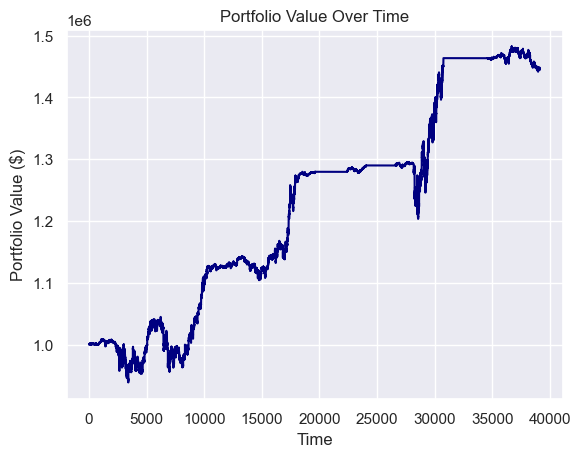

In [15]:
plt.plot(portfolio_value, color = 'navy')
plt.title('Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Portfolio Value ($)')
plt.show()